In [410]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import plot_importance

# Load the dataset
df = pd.read_csv("/Users/kristenauriemma/595Project/USvideos.csv")

# Convert 'trending_date' to datetime format (DD.MM.YY)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%d.%m.%y', errors='coerce')

# Check how many rows have invalid 'trending_date' (NaT)
invalid_trending_date_count = df['trending_date'].isna().sum()

# Drop rows with invalid 'trending_date' but keep those with valid views
df = df.dropna(subset=['trending_date'])

# Handle missing values in other columns
# Fill missing numeric columns with the mean
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Create a 7-day moving average of views
df['views_7d_avg'] = df.groupby('video_id')['views'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)

# Verify if the new feature has been added correctly
print(df[['video_id', 'trending_date', 'views', 'views_7d_avg']].head())

# Split the data into features (X) and target (y)
X = df.drop(columns=['views'])  # Features (drop the target column 'views')
y = df['views']  # Target variable (views)

# Ensure that 'publish_time' and 'trending_date' are properly formatted
df['publish_time'] = pd.to_datetime(df['publish_time']).dt.tz_localize(None)
df['trending_date'] = pd.to_datetime(df['trending_date']).dt.tz_localize(None)

# Create new features
df['publish_hour'] = df['publish_time'].dt.hour  # Extract the hour of the day the video was published
df['publish_weekday'] = df['publish_time'].dt.weekday  # 0=Monday, 6=Sunday
df['days_since_publish'] = (df['trending_date'] - df['publish_time']).dt.days  # Number of days since the video was published


         video_id trending_date     views  views_7d_avg
3400  6ZfuNTqbHE8    2012-01-17  56367282    56367282.0
3401  nx1R-eHSkfM    2012-01-17   1894443     1894443.0
3402  XbuQAbG2AZ0    2012-01-17    224270      224270.0
3403  evhLzq7Gsak    2012-01-17   1717225     1717225.0
3404  KXHrCBkIxQQ    2012-01-17    616077      616077.0


In [412]:
# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop categorical columns (e.g., video_id, title, etc.) 
columns_to_drop = ['video_id', 'title', 'channel_title', 'tags', 'description']
X_train = X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns])
X_test = X_test.drop(columns=[col for col in columns_to_drop if col in X_test.columns])

# Select numeric columns after dropping categorical columns
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# Handle missing values for both training and testing datasets
X_train = X_train.fillna(X_train.mean())  # Fill missing values in training data
X_test = X_test.fillna(X_test.mean())    # Fill missing values in testing data

# Scale the data using the same scaler for both training and testing datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform X_train
X_test_scaled = scaler.transform(X_test)  # Only transform X_test

# Print out the shapes of the training and testing sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 12300 samples
Testing set size: 3075 samples


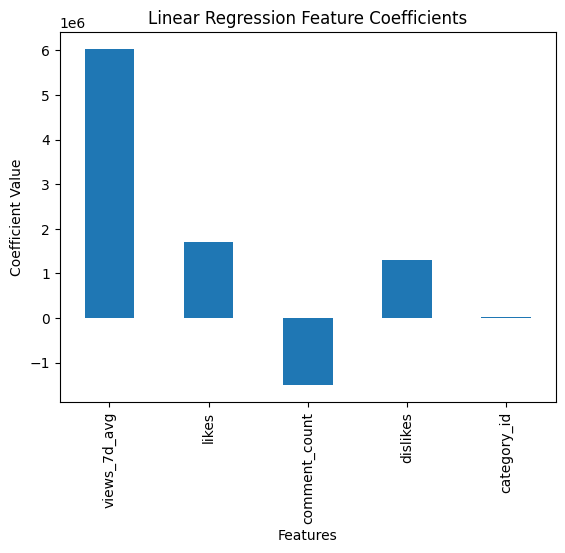

Linear Regression MSE: 1190317685353.3438, R²: 0.970536382383715


In [414]:
# Create and fit a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions with the Linear Regression model
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate the Linear Regression model
lr_mse = mean_squared_error(y_test, lr_pred)  # Mean Squared Error (MSE)
lr_r2 = r2_score(y_test, lr_pred)  # R-squared score

# Create and fit the model using scaled data for coefficients display
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

# Display feature importance (coefficients)
coefficients = pd.DataFrame(model_lr.coef_, X_train.columns, columns=['Coefficient'])
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()  
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Linear Regression Coefficients Plot
coefficients['Coefficient'].plot(kind='bar')
plt.title('Linear Regression Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

# Print Linear Regression performance
print(f"Linear Regression MSE: {lr_mse}, R²: {lr_r2}")

##### 7-Day Average Views - The views_7day_avg feature has the highest coefficient, significantly outpacing others, indicating it is the strongest predictor of total views. This metric captures recent engagement, showing that videos consistently attracting views over the past week are highly likely to continue trending.

##### Likes - Although less impactful than the 7-day average, likes are still a substantial factor in view count prediction, with a positive but smaller coefficient. High like counts are a strong indication of popularity and positive reception, both of which contribute meaningfully to overall views.

##### Dislikes - Dislikes, though traditionally negative, show a smaller positive correlation with view count. This suggests that polarizing content, which garners more dislikes, may still drive viewer curiosity and engagement.

##### Comment Count - Comments also contribute to view predictions but to a lesser degree. Engagement through comments signals active interaction but does not influence view count as strongly as likes, dislikes, or recent view trends.

##### Publish Time - Publish time had minimal correlation with views, suggesting that timing alone does not strongly influence a video’s popularity or its potential to trend.

XGBoost MSE: 2660551618511.7676, R²: 0.9341440722079593


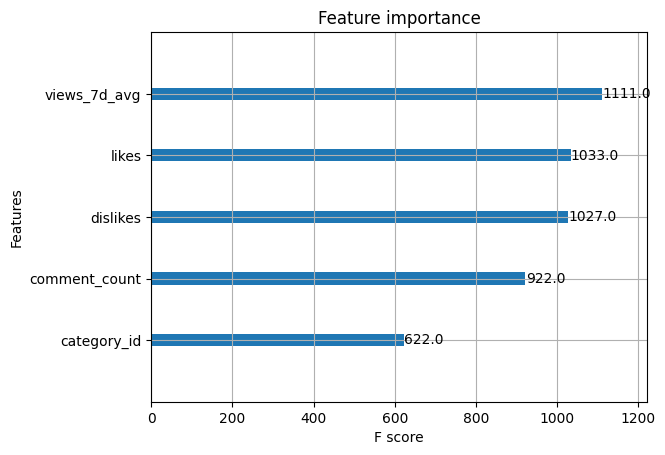

In [417]:
# Create and fit an XGBoost model
xg_model = xgb.XGBRegressor()
xg_model.fit(X_train_scaled, y_train)

# Make predictions with the XGBoost model
xg_pred = xg_model.predict(X_test_scaled)

# Evaluate the XGBoost model
xg_mse = mean_squared_error(y_test, xg_pred)  # Mean Squared Error (MSE)
xg_r2 = r2_score(y_test, xg_pred)  # R-squared score

# Fit the model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_xgb, importance_type='weight')

# XGBoost
print(f"XGBoost MSE: {xg_mse}, R²: {xg_r2}")

##### Views 7-Day Average: This feature has the highest influence on predicting the view count, with both linear regression and itself showing it as the strongest predictor. In XGBoost, it has an importance score of 1111 which is higher than the other features. This suggests that recent viewing trends strongly impact a video's future popularity.

##### Likes: Likes are the next most influential feature, with an XGBoost score of 1,033 and a moderate linear regression coefficient. While not as impactful as the 7-day view average, likes still provide a strong indication of viewer approval and engagement.

##### Dislikes: Dislikes have a similar importance to likes (XGBoost score of 1,027), showing that both positive and negative reactions are indicators of viewer engagement. However, dislikes lag behind in impact.

##### Comment Count: With an XGBoost score of 922, comment count also plays a role, reflecting that videos with more comments tend to generate more interest.

##### Category: This feature has some influence (XGBoost score of 622), indicating that certain categories may naturally attract more views.


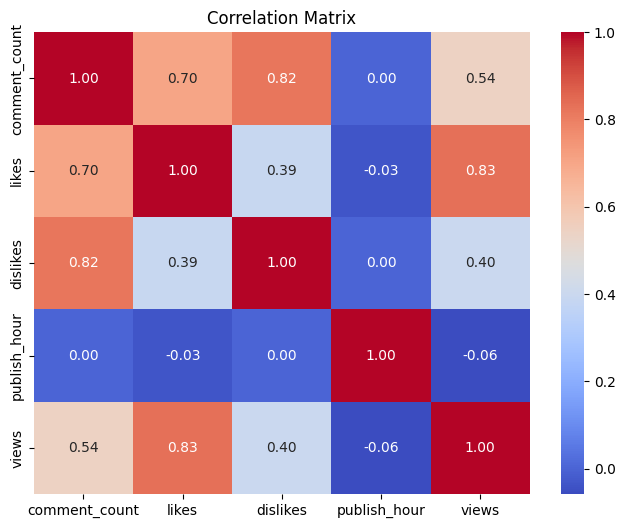

Correlation between comment_count and views: 0.543
Correlation between likes and views: 0.832
Correlation between dislikes and views: 0.398
Correlation between publish_hour and views: -0.059


In [420]:
# Numeric columns for correlation calculation
numeric_features = ['comment_count', 'likes', 'dislikes', 'publish_hour', 'views']
correlation_scores = df[numeric_features].corr()

# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_scores, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the individual correlations with views
for feature in numeric_features:
    if feature != 'views':  # Don't calculate correlation for the target itself
        correlation_score = df[feature].corr(df['views'])
        print(f"Correlation between {feature} and views: {correlation_score:.3f}")


##### There is a moderate positive correlation between the number of comments and views. As the number of views increases, it's reasonable to expect the number of comments to also increase. While this is a significant relationship, it's not very strong, meaning that other factors could be influencing the views more.

##### There is a strong positive correlation between the number of likes and views. This suggests that videos with more views tend to receive more likes. This relationship is stronger than with comments, indicating that likes are more directly linked to the popularity or engagement of a video. Likes have the strongest and most positive correlation with views, suggesting they are a good indicator of video popularity.

##### There is a weak to moderate positive correlation between the number of dislikes and views. While the correlation is positive, it is much weaker compared to likes and comments. This might suggest that videos with high views might still receive a certain number of dislikes, but dislikes don’t have as strong a relationship with views as likes or comments do.

##### There is a very weak negative correlation between the publish hour and views. This suggests that the time of day a video is published does not strongly influence the number of views. The negative correlation is so weak that it may not be practically significant. 

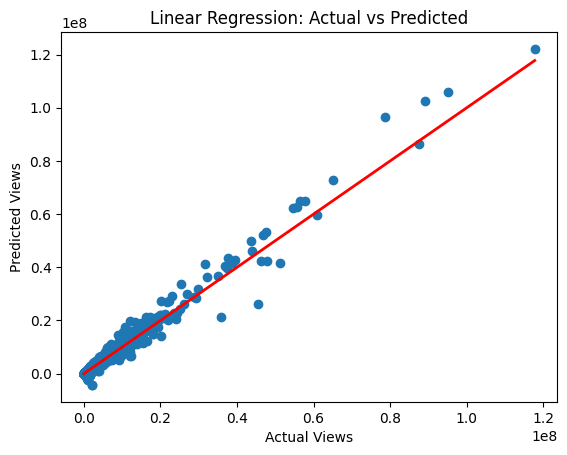

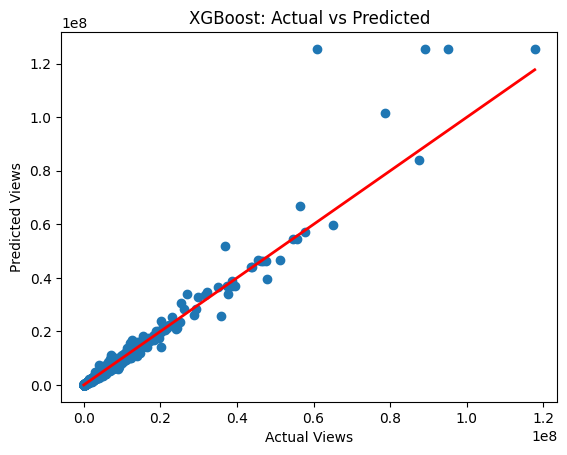

In [423]:
# Predicted vs Actual for Linear Regression
plt.scatter(y_test, lr_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

# Predicted vs Actual for XGBoost
plt.scatter(y_test, xg_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()


In [425]:
# Comparison of model performance 
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost'],
    'MSE': [lr_mse, xg_mse],
    'R²': [lr_r2, xg_r2]
})
print(model_comparison)


               Model           MSE        R²
0  Linear Regression  1.190318e+12  0.970536
1            XGBoost  2.660552e+12  0.934144
